In [137]:
import pandas as pd 
import matplotlib as mpl
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math

# reading and storing data
data = pd.read_csv('credit_card_fraud.csv', parse_dates=['trans_date_trans_time',])




In [132]:
# Method to calculate the distance between to longitude and latitude points.
# Since we have both the customer (lat, long) at time of purchase and the merchant's (lat,long) we can compute the distance between the two
# this could lead us seeing if the is any correlation between how far a purchase is and if it is fraud or not
def distance(lat1, lon1, lat2, lon2):
    # radius of the Earth in km
    R = 6371.0

    # convert degrees to radians
    lat1 = math.radians(lat1)
    lon1 = math.radians(lon1)
    lat2 = math.radians(lat2)
    lon2 = math.radians(lon2)

    # compute the differences between the two points
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    # compute the Haversine formula
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    dist = R * c

    return dist

Data comes from 1st Jan 2019 - 31st Dec 2020. It covers credit cards of 1000 customers doing transactions with a pool of 800 merchants. From the Western United States

In [138]:
# changing data types
data['dob'] = pd.to_datetime(data['dob'])

# creating columns out of our original Dataset --------------------------

data['hour_of_transaction'] = data.trans_date_trans_time.dt.hour # hour of transaction
data['month_of_transaction'] = data.trans_date_trans_time.dt.month # month of transaction
data['dow_of_transaction'] = data.trans_date_trans_time.dt.day_name() # day of week of transaction
data['cust_age'] = (data['trans_date_trans_time'] - data['dob']).astype('timedelta64[Y]') # age of person during transaction
data['distance_of_transaction'] = data.apply(lambda row: distance(row['lat'], row['long'], row['merch_lat'], row['merch_long']), axis=1)

# print the updated DataFrame
# encoding: 0 = normal time, 1 = odd time
data['Normal_transaction_time'] = 0
data.loc[data.hour_of_transaction < 5,'Normal_transaction_time'] = 1
data.loc[data.hour_of_transaction > 21,'Normal_transaction_time'] = 1

data = data.drop(columns=['trans_date_trans_time'])

From here we are showing some interesting data that we extracted from our dataset.
The data shown below can help us understand more about our data as well as help us pinpoint some factors that may be better than others in detecting fraud.

1. A heatmap correlation between each feature, this can show us what features are correlated the most with fraud.
2. The number of Fraud purchases in each state/The percent of Fraud in each state
3. The number of Fraud purchases in each category of purchase/The percent of Fraud purchases in each category of purchase
4. The hours of day where Fraud occurs/ The percent of fraud @ each hour & its distribution
5. The number of Fraud purchases at each age/The percent of Fraud at each age & its distribution
6. The number of Fraud purchases in each day/The percent of Fraud purchases each day
7. The number of Fraud purchases in each month/The percent of Fraud purchases each month & its distribution



In [139]:
data.head()

,merchant,category,amt,city,state,lat,long,city_pop,job,dob,trans_num,merch_lat,merch_long,is_fraud,hour_of_transaction,month_of_transaction,dow_of_transaction,cust_age,distance_of_transaction,Normal_transaction_time
0,"Heller, Gutmann and Zieme",grocery_pos,107.23,Orient,WA,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,49.159047,-118.186462,0,0,1,Tuesday,40.0,30.212176,1
1,Lind-Buckridge,entertainment,220.11,Malad City,ID,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,43.150704,-112.154481,0,0,1,Tuesday,56.0,108.206083,1
2,Kiehn Inc,grocery_pos,96.29,Grenada,CA,41.6125,-122.5258,589,Systems analyst,1945-12-21,413636e759663f264aae1819a4d4f231,41.657520,-122.230347,0,0,1,Tuesday,73.0,25.059079,1
3,Beier-Hyatt,shopping_pos,7.77,High Rolls Mountain Park,NM,32.9396,-105.8189,899,Naval architect,1967-08-30,8a6293af5ed278dea14448ded2685fea,32.863258,-106.520205,0,0,1,Tuesday,51.0,66.021685,1
4,Bruen-Yost,misc_pos,6.85,Freedom,WY,43.0172,-111.0292,471,"Education officer, museum",1967-08-02,f3c43d336e92a44fc2fb67058d5949e3,43.753735,-111.454923,0,0,1,Tuesday,51.0,88.830984,1


/var/folders/8d/61ydjft161g6rbl7cxg49_g80000gn/T/ipykernel_8630/3063559326.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr(), cmap='crest', annot=True)


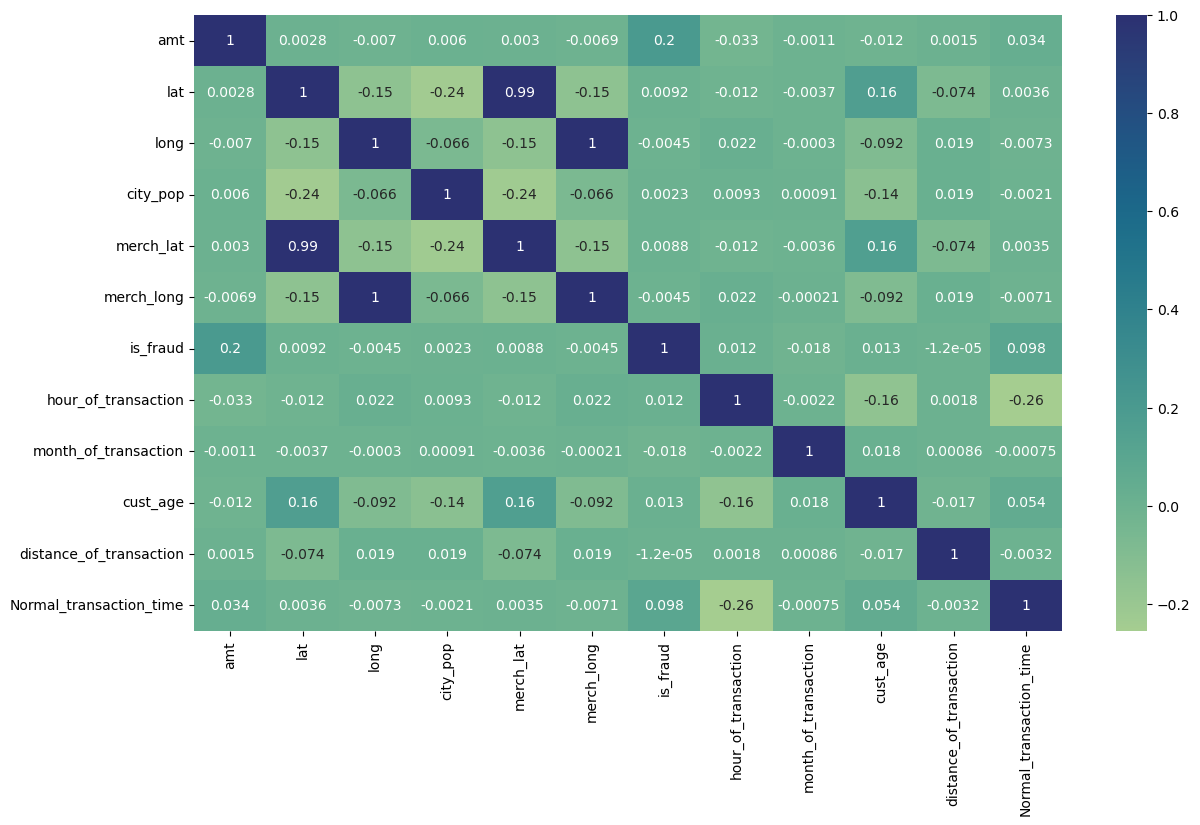

In [140]:
# Heatmap
fig = plt.figure(figsize=(14,8))
sns.heatmap(data.corr(), cmap='crest', annot=True)
plt.show()

From this heatmap we can find some interesting things.

We notice that the 5 most features that correlate the most with our class identifier 'is_fraud' are:

1. amt (.2)
2. normal_transaction_time (.098)
3. cust_age (.013)
4. hour_of_transaction (.012)
5. lat (.0092) 

Text(0.5, 0, 'States')

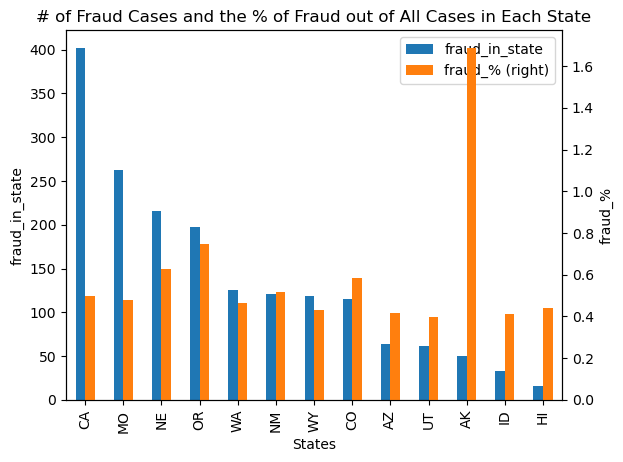

In [58]:
fraud_state_df = pd.DataFrame({'fraud_in_state': data.query('is_fraud==1')['state'].value_counts(),
                               'fraud_%' : data.query('is_fraud==1')['state'].value_counts()/data['state'].value_counts()*100})
fraud_state_df = fraud_state_df.sort_values('fraud_in_state', ascending=False)
ax = fraud_state_df.plot.bar(secondary_y = ['fraud_%'])
ax.set_ylabel('fraud_in_state')
ax.right_ax.set_ylabel('fraud_%')
ax.set_title('# of Fraud Cases and the % of Fraud out of All Cases in Each State')
ax.set_xlabel('States')

Text(0.5, 0, 'Categories')

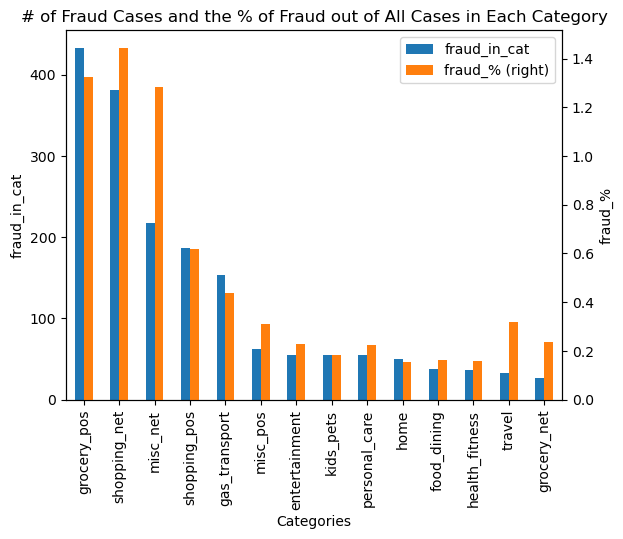

In [49]:
fraud_cat_df = pd.DataFrame({'fraud_in_cat': data.query('is_fraud==1')['category'].value_counts(),
                               'fraud_%' : data.query('is_fraud==1')['category'].value_counts()/data['category'].value_counts()*100})
fraud_cat_df = fraud_cat_df.sort_values('fraud_in_cat', ascending=False)
ax = fraud_cat_df.plot.bar(secondary_y = ['fraud_%'])
ax.set_ylabel('fraud_in_cat')
ax.right_ax.set_ylabel('fraud_%')
ax.set_title('# of Fraud Cases and the % of Fraud out of All Cases in Each Category')
ax.set_xlabel('Categories')


Text(0.5, 0, 'Hours of Day')

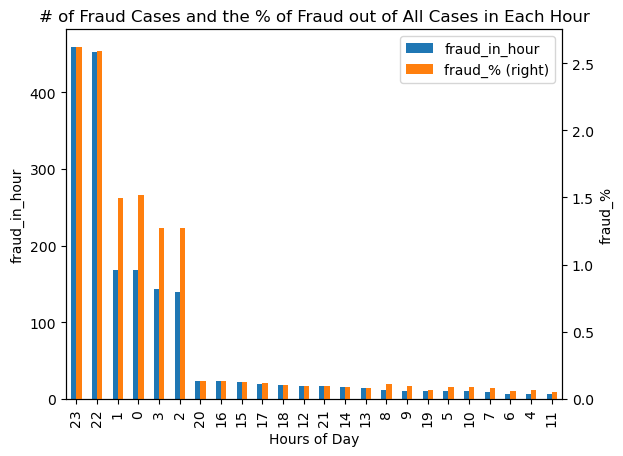

In [59]:
fraud_hour_df = pd.DataFrame({'fraud_in_hour': data.query('is_fraud==1')['hour_of_transaction'].value_counts(),
                               'fraud_%' : data.query('is_fraud==1')['hour_of_transaction'].value_counts()/data['hour_of_transaction'].value_counts()*100})
fraud_hour_df = fraud_hour_df.sort_values('fraud_in_hour', ascending=False)
ax = fraud_hour_df.plot.bar(secondary_y = ['fraud_%'])
ax.set_ylabel('fraud_in_hour')
ax.right_ax.set_ylabel('fraud_%')
ax.set_title('# of Fraud Cases and the % of Fraud out of All Cases in Each Hour')
ax.set_xlabel('Hours of Day')

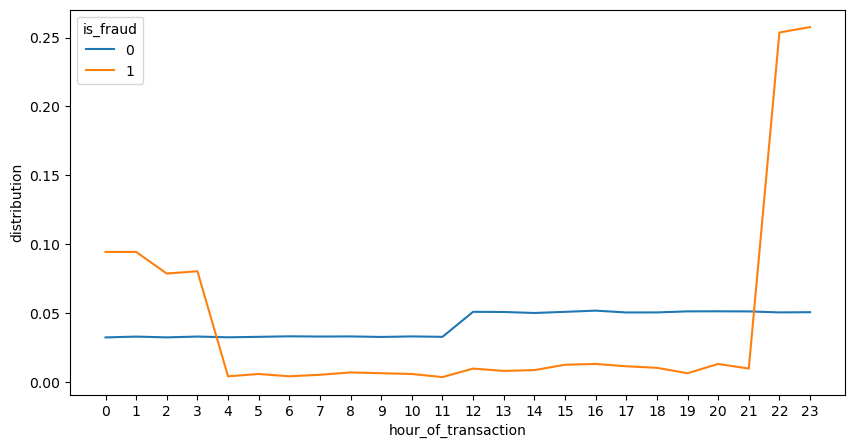

In [129]:
plt.figure(figsize=(10,5))
age_distribution = data.groupby('is_fraud')['hour_of_transaction'].value_counts(normalize = True).rename('distribution').reset_index()
sns.lineplot(data = age_distribution, x = 'hour_of_transaction', y = 'distribution', hue='is_fraud') 
plt.xticks(np.arange(0,24,1)); 

Text(0.5, 0, 'Age')

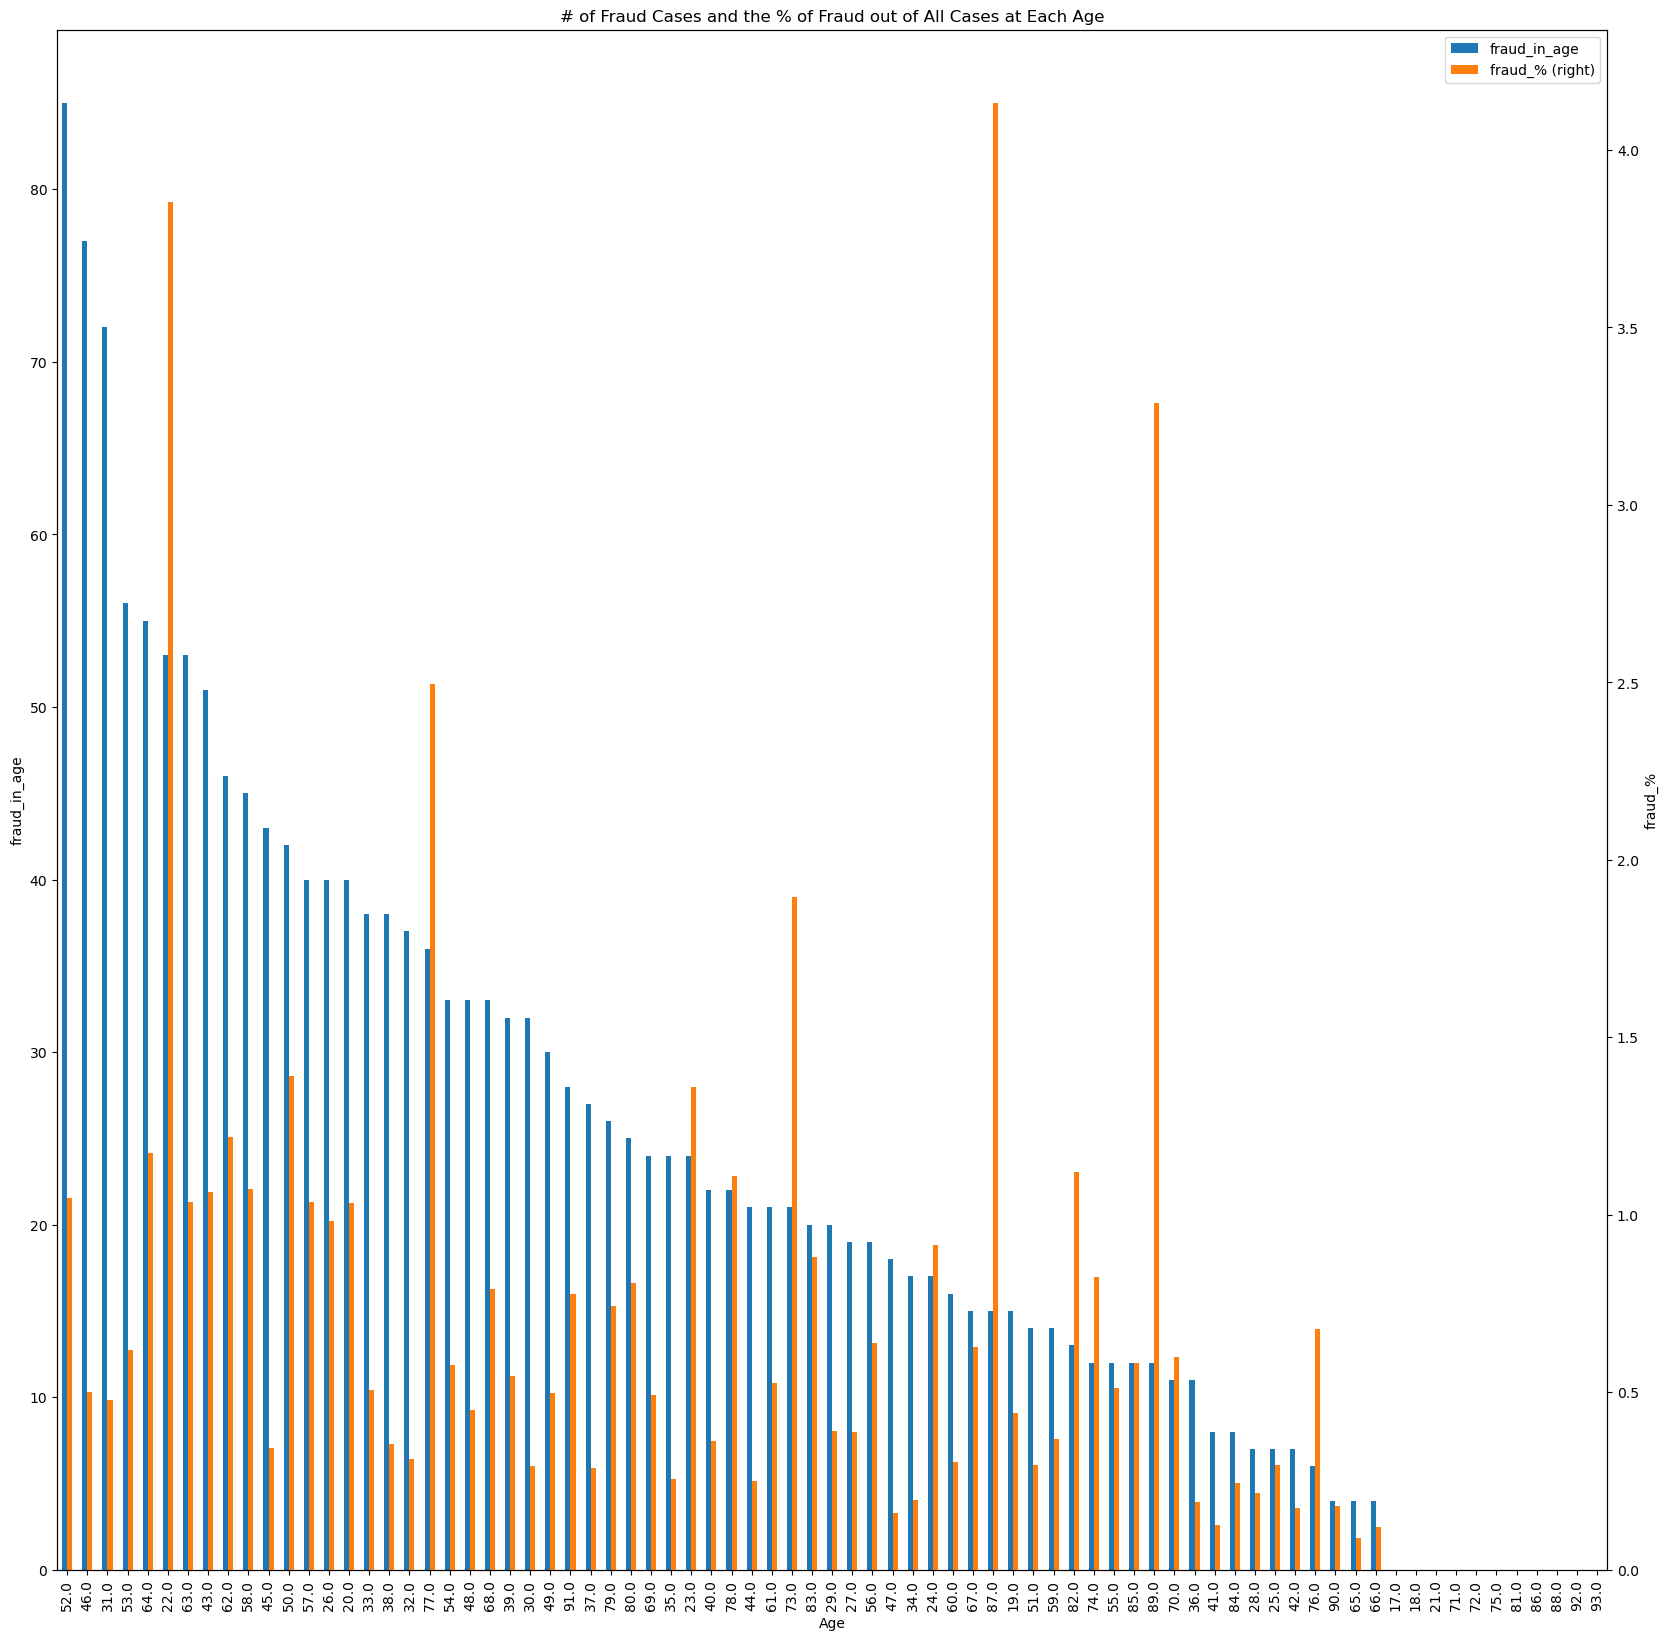

In [71]:
fraud_age_df = pd.DataFrame({'fraud_in_age': data.query('is_fraud==1')['cust_age'].value_counts(),
                               'fraud_%' : data.query('is_fraud==1')['cust_age'].value_counts()/data['cust_age'].value_counts()*100})
fraud_age_df = fraud_age_df.sort_values('fraud_in_age', ascending=False)
ax = fraud_age_df.plot.bar(secondary_y = ['fraud_%'], figsize=(20,20))
ax.set_ylabel('fraud_in_age')
ax.right_ax.set_ylabel('fraud_%')
ax.set_title('# of Fraud Cases and the % of Fraud out of All Cases at Each Age')
ax.set_xlabel('Age')

In [98]:
fraud_age_df.head()

,fraud_in_age,fraud_%
52.0,85.0,1.048089
46.0,77.0,0.499838
31.0,72.0,0.476821
53.0,56.0,0.619469
64.0,55.0,1.173709


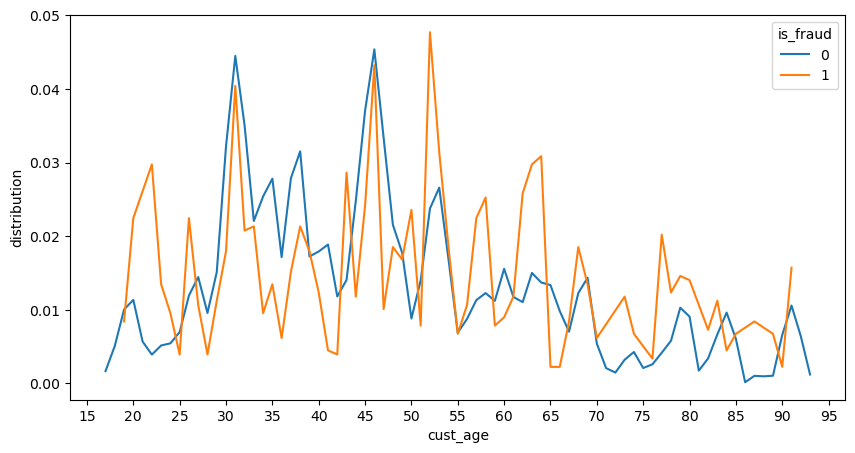

In [121]:
plt.figure(figsize=(10,5))
age_distribution = data.groupby('is_fraud')['cust_age'].value_counts(normalize = True).rename('distribution').reset_index()
sns.lineplot(data = age_distribution, x = 'cust_age', y = 'distribution', hue='is_fraud') 
plt.xticks(np.arange(15,100,5)); 

Text(0.5, 0, 'Day')

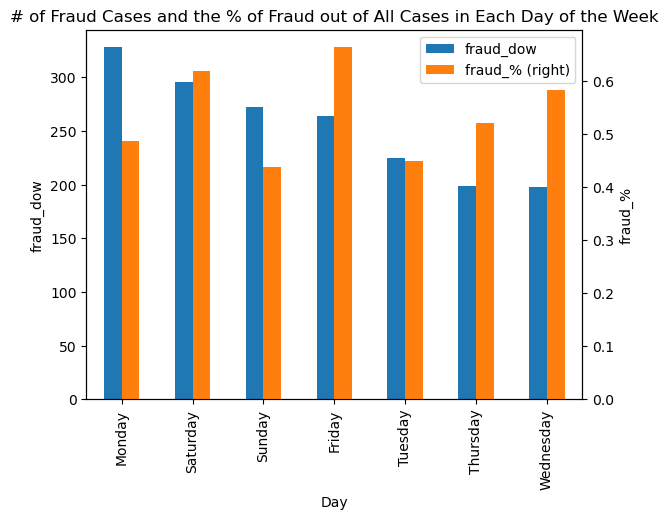

In [72]:
fraud_dow_df = pd.DataFrame({'fraud_dow': data.query('is_fraud==1')['dow_of_transaction'].value_counts(),
                               'fraud_%' : data.query('is_fraud==1')['dow_of_transaction'].value_counts()/data['dow_of_transaction'].value_counts()*100})
fraud_dow_df = fraud_dow_df.sort_values('fraud_dow', ascending=False)
ax = fraud_dow_df.plot.bar(secondary_y = ['fraud_%'])
ax.set_ylabel('fraud_dow')
ax.right_ax.set_ylabel('fraud_%')
ax.set_title('# of Fraud Cases and the % of Fraud out of All Cases in Each Day of the Week')
ax.set_xlabel('Day')

Text(0.5, 0, 'Month')

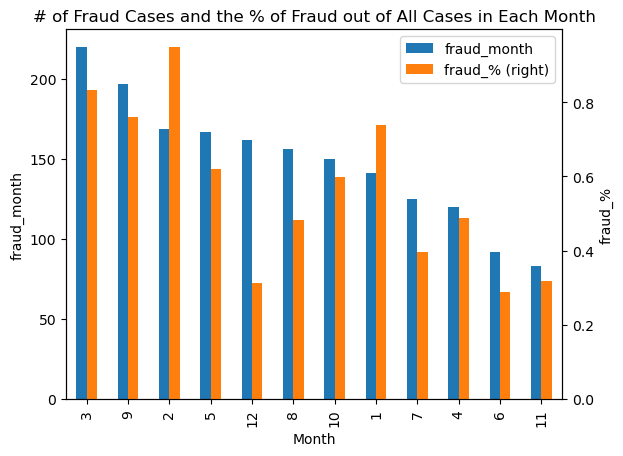

In [73]:
fraud_month_df = pd.DataFrame({'fraud_month': data.query('is_fraud==1')['month_of_transaction'].value_counts(),
                               'fraud_%' : data.query('is_fraud==1')['month_of_transaction'].value_counts()/data['month_of_transaction'].value_counts()*100})
fraud_month_df = fraud_month_df.sort_values('fraud_month', ascending=False)
ax = fraud_month_df.plot.bar(secondary_y = ['fraud_%'])
ax.set_ylabel('fraud_month')
ax.right_ax.set_ylabel('fraud_%')
ax.set_title('# of Fraud Cases and the % of Fraud out of All Cases in Each Month')
ax.set_xlabel('Month')

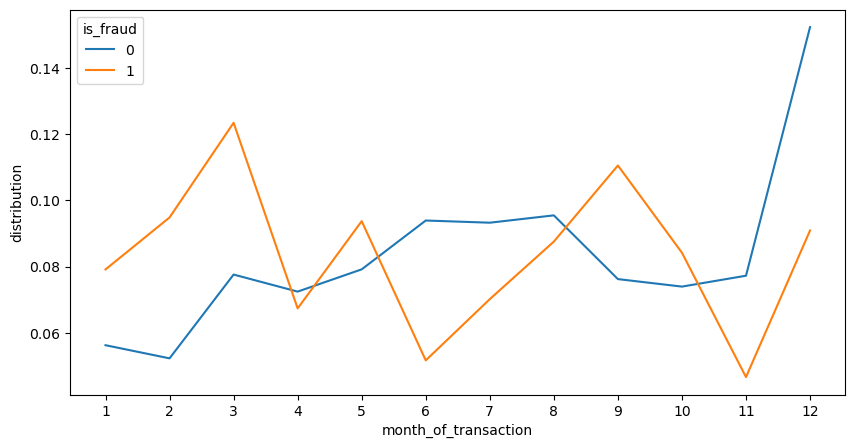

In [126]:
plt.figure(figsize=(10,5))
age_distribution = data.groupby('is_fraud')['month_of_transaction'].value_counts(normalize = True).rename('distribution').reset_index()
sns.lineplot(data = age_distribution, x = 'month_of_transaction', y = 'distribution', hue='is_fraud') 
plt.xticks(np.arange(1,13,1)); 